In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import pickle
from keras.callbacks import EarlyStopping



Using TensorFlow backend.
C:\Users\menoci\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\menoci\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\menoci\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\menoci\AppData

In [2]:
def pca_analysis(X_train, hs = [1, 2, 3, 4] ):
    dict_pca = {}
    dict_e_pca_train = {}
    dict_var_exp_train = {}
    dict_e_pca_test = {}


    for h in hs:
        dict_pca[h] = PCA(n_components = h)
        dict_pca[h].fit(X_train)
        pca = dict_pca[h]
        Z_train = pca.transform(X_train)
        Xtilde_train = pca.inverse_transform(Z_train)
        e_pca_train = mean_squared_error(X_train, Xtilde_train)
        var_exp_train = np.sum(pca.explained_variance_ratio_)
        dict_e_pca_train[h] = e_pca_train
        dict_var_exp_train[h] = var_exp_train
        Z_test = pca.transform(X_test)
        Xtilde_test = pca.inverse_transform(Z_test)
        e_pca_test = mean_squared_error(X_test, Xtilde_test)
        dict_e_pca_test[h] = e_pca_test
        print("SKL PCA, h =", h, "PCs, reconstruction error:", str(round(e_pca_train, 4)),
              "total ratio of variance explained:", str(round(var_exp_train, 4)))
        
    return

In [27]:
#df = pd.read_csv('features_random_10k_ci1e-2_cf1_ns60_pf0.5_vi2_vf10_si50_sf250')
df = pd.read_csv('features_random_fixed_n_50k_ci1e-2_cf1_ns60_pf0.5_vi2_vf10_si50_500_1000')
#df = pd.read_csv('features_mix_size2_ci1e-2_cf1_ns60_pf0.5_vi2_vf10_si50_sf250_ssize20')

In [8]:
df

,c,v,n,R-,R+,c_moment,std_moment
0,0.665921,2.814601,50,1.446154,36.946154,0.642307,1.024827
1,0.564547,8.793024,50,1.542308,32.057692,0.599314,1.004986
2,0.426391,7.996178,50,2.088462,23.023077,0.380732,1.010784
3,0.825986,8.497463,500,1.350996,373.871713,0.819446,0.987519
4,0.591224,7.627212,500,1.580478,318.382072,0.612809,0.988842
...,...,...,...,...,...,...,...
49995,0.793541,3.166848,1000,1.259880,794.925349,0.802391,0.976718
49996,0.708365,6.863682,500,1.456972,341.197610,0.700025,0.994663
49997,0.305904,6.705332,1000,2.752894,365.887425,0.294990,0.997959
49998,0.780515,7.517548,500,1.373307,363.535458,0.790057,1.000916


In [9]:
def prepare_data(df, test_size = 0.15):
    Y = df['c']
    #X = df.iloc[:,1:]

    X_train, X_test, Y_train, Y_test = train_test_split(df, Y, 
                                                        shuffle = True, 
                                                        test_size = test_size, random_state=10)
    SR_moment_train = X_train['c_moment']/X_train['std_moment']
    SR_moment_test = X_test['c_moment']/X_test['std_moment']
    
    X_train = X_train[['v' , 'n', 'R-', 'R+']]
    X_test = X_test[['v' , 'n', 'R-', 'R+']]
    
    return X_train, X_test, Y_train, Y_test, SR_moment_test

In [28]:
X_train, X_test, Y_train, Y_test, SR_moment_test = prepare_data(df)

## Let's apply PCA to see whether the features space can have its dimension reduced in order to avoid overfitting

In [11]:
pca_analysis(X_train)

SKL PCA, h = 1 PCs, reconstruction error: 4503.8319 total ratio of variance explained: 0.9167
SKL PCA, h = 2 PCs, reconstruction error: 2.8819 total ratio of variance explained: 0.9999
SKL PCA, h = 3 PCs, reconstruction error: 1.2708 total ratio of variance explained: 1.0
SKL PCA, h = 4 PCs, reconstruction error: 0.0 total ratio of variance explained: 1.0


In [12]:
#plt.plot(dict_pca[3].components_[2], 'x')

### Let's normalize the features

In [13]:
scaler = StandardScaler().fit(X_train)
X_train_n = scaler.transform(X_train)
X_test_n = scaler.transform(X_test)
X_test_n = pd.DataFrame(X_test_n, columns=X_test.columns)

In [14]:
pca_analysis(X_train_n)

SKL PCA, h = 1 PCs, reconstruction error: 0.5414 total ratio of variance explained: 0.4586
SKL PCA, h = 2 PCs, reconstruction error: 0.2703 total ratio of variance explained: 0.7297
SKL PCA, h = 3 PCs, reconstruction error: 0.0249 total ratio of variance explained: 0.9751
SKL PCA, h = 4 PCs, reconstruction error: 0.0 total ratio of variance explained: 1.0


In [15]:
# Saving the Scaler
filename = 'scaler_2to30'
pickle.dump(scaler, open(filename, 'wb'))

In [198]:
#filename = 'scaler_2to30'
#loaded_model = pickle.load(open(filename, 'rb'))
#X2_n = scaler.transform(X2)
#X_test_n = loaded_model.transform(X_test)

In [16]:
m = Sequential()
m.add(Dense(30,  activation='relu', input_shape=(4,)))
#m.add(Dense(30,  activation='relu'))
#m.add(Dense(30,  activation='relu')) 
m.add(Dense(20,  activation='relu')) 
m.add(Dense(15,  activation='relu')) 
m.add(Dense(10,  activation='relu'))
m.add(Dense(7,  activation='relu'))
m.add(Dense(5,  activation='relu'))
m.add(Dense(3,  activation='relu'))
m.add(Dense(1,  activation='linear'))
m.compile(loss='mean_squared_error', optimizer = Adam(), metrics=['mape'])

earlyStopping = EarlyStopping(monitor='val_mape', patience=10, verbose=0, mode='min') #Create early stop routine

history = m.fit(X_train_n, Y_train, epochs=100, verbose=1, validation_data = (X_test_n, Y_test), callbacks=[earlyStopping])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 42500 samples, validate on 7500 samples
Epoch 1/100
42500/42500 [==============================] - 4s 86us/step - loss: 0.0102 - mean_absolute_percentage_error: 23.2025 - val_loss: 0.0025 - val_mean_absolute_percentage_error: 14.0440
Epoch 2/100
 3168/42500 [=>............................] - ETA: 1s - loss: 0.0026 - mean_absolute_percentage_error: 12.9250

C:\Users\menoci\AppData\Roaming\Python\Python37\site-packages\keras\callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_mape` which is not available. Available metrics are: val_loss,val_mean_absolute_percentage_error,loss,mean_absolute_percentage_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


42500/42500 [==============================] - 2s 55us/step - loss: 0.0021 - mean_absolute_percentage_error: 12.5213 - val_loss: 0.0020 - val_mean_absolute_percentage_error: 12.7024
Epoch 3/100
42500/42500 [==============================] - 2s 53us/step - loss: 0.0019 - mean_absolute_percentage_error: 11.9050 - val_loss: 0.0019 - val_mean_absolute_percentage_error: 11.9063
Epoch 4/100
42500/42500 [==============================] - 2s 52us/step - loss: 0.0018 - mean_absolute_percentage_error: 11.3792 - val_loss: 0.0017 - val_mean_absolute_percentage_error: 11.8212
Epoch 5/100
42500/42500 [==============================] - 2s 51us/step - loss: 0.0018 - mean_absolute_percentage_error: 11.2211 - val_loss: 0.0023 - val_mean_absolute_percentage_error: 12.7590
Epoch 6/100
42500/42500 [==============================] - 2s 48us/step - loss: 0.0017 - mean_absolute_percentage_error: 10.8705 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 11.6130
Epoch 7/100
42500/42500 [=================

42500/42500 [==============================] - 2s 53us/step - loss: 0.0014 - mean_absolute_percentage_error: 9.8133 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 10.5795
Epoch 45/100
42500/42500 [==============================] - 2s 53us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.7189 - val_loss: 0.0016 - val_mean_absolute_percentage_error: 10.8541
Epoch 46/100
42500/42500 [==============================] - 2s 52us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.8664 - val_loss: 0.0015 - val_mean_absolute_percentage_error: 10.9427
Epoch 47/100
42500/42500 [==============================] - 2s 53us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.8080 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 10.4292
Epoch 48/100
42500/42500 [==============================] - 2s 53us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.6985 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 10.6038
Epoch 49/100
42500/42500 [=================

42500/42500 [==============================] - 2s 53us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.3816 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 10.2560
Epoch 87/100
42500/42500 [==============================] - 2s 54us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.5212 - val_loss: 0.0013 - val_mean_absolute_percentage_error: 9.5772
Epoch 88/100
42500/42500 [==============================] - 2s 53us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.4170 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 9.9934
Epoch 89/100
42500/42500 [==============================] - 2s 55us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.4119 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 9.6867
Epoch 90/100
42500/42500 [==============================] - 2s 59us/step - loss: 0.0013 - mean_absolute_percentage_error: 9.3939 - val_loss: 0.0012 - val_mean_absolute_percentage_error: 9.6219
Epoch 91/100
42500/42500 [=====================

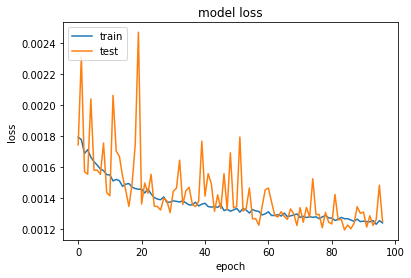

In [17]:
# summarize history for loss
plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [18]:
def mape_error(y_true, y_pred):
    return np.average(np.abs((y_true-y_pred.squeeze())/y_true))#np.abs((y_true-y_pred)/y_true)

In [19]:
filt = (X_test['n'] == 50)
mean_squared_error(Y_test[filt], m.predict(scaler.transform(X_test[filt])))

0.0030301195395770345

In [20]:
mape_error(Y_test[filt],m.predict(scaler.transform(X_test[filt]))) * 100

20.86533351709786

In [21]:
# Saving the model
filename = 'NN-v-2-30-MAE-2.41'
pickle.dump(m, open(filename, 'wb'))

In [22]:
filename = 'NN-v-2-30-MAE-2.41'
m = pickle.load(open(filename, 'rb'))

## Analysis of the error in function of the degrees of fredoom v

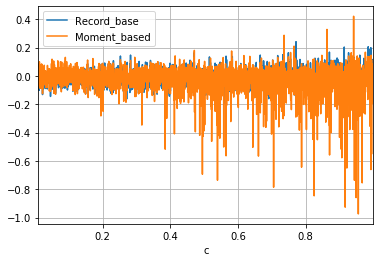

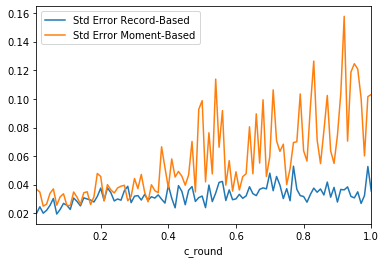

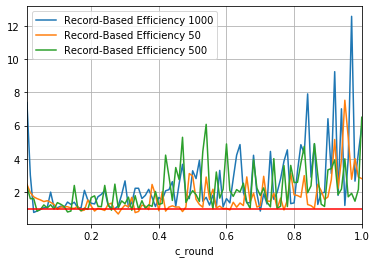

In [25]:
df = pd.read_csv('features_random_fixed_n_50k_ci1e-2_cf1_ns60_pf0.5_vi2_vf10_si50_500_1000')
X_train, X_test, Y_train, Y_test, SR_moment_test = prepare_data(df)

model = m
Y_test_moment = SR_moment_test
feature = 'c'

v = np.array(X_test['v'])
c = np.array(Y_test)
n = np.array(X_test['n'])


X_test = scaler.transform(X_test)

err = np.array(Y_test)-np.array(model.predict(X_test).squeeze())

err_moment = np.array(Y_test) - np.array(Y_test_moment)

e = pd.DataFrame()
e['v'] = v
e['c'] = c
e['n'] = n
e['err'] = err
e['err_moment'] = err_moment


e['v_round']=np.around(e['v'],decimals=1)
e['c_round'] = np.around(e['c'], decimals = 2)

    

eavg=e.groupby(feature).mean()

eavg['err'].plot(label = 'Record_base', legend = True)
eavg['err_moment'].plot(label = 'Moment_based', legend = True)
plt.grid(True)

plt.show()





#Plot standard deviation
eavg=e.groupby('c_round').std()
eavg['err'].plot(label = 'Std Error Record-Based', legend = True)
eavg['err_moment'].plot(label = 'Std Error Moment-Based', legend = True)

plt.show()
    
for n_value in set(n):
    eavg=e[e['n'] == n_value].groupby('c_round').std()
    eavg['ratio_std'] = eavg['err_moment']/eavg['err']
    eavg['ratio_std'].plot(label = 'Record-Based Efficiency ' + str(n_value), legend = True)

plt.plot([1]*len(eavg['ratio_std']),'r') #Compare efficiency with 1

plt.grid(True)
plt.show()


In [266]:
eavg=e[e['n'] == n_value].groupby('c_round').std()

In [270]:
eavg

,v,c,n,err,err_moment,v_round
c_round,,,,,,
0.01,2.075779,0.001512,0.0,0.015673,0.011178,2.079336
0.02,2.191464,0.003001,0.0,0.005452,0.009398,2.184125
0.03,2.052371,0.002822,0.0,0.007234,0.009257,2.051896
0.04,2.232584,0.003194,0.0,0.008887,0.011758,2.230254
0.05,2.527607,0.003275,0.0,0.011193,0.010075,2.519060
...,...,...,...,...,...,...
0.96,2.153106,0.003016,0.0,0.014095,0.054321,2.157065
0.97,2.607142,0.003141,0.0,0.011295,0.144217,2.615245
0.98,2.399990,0.002982,0.0,0.010583,0.026588,2.401587


In [26]:
def plot_error(model, X_test, Y_test, Y_test_moment, scaler, feature, by_n, scatter_plot = True):
    v = np.array(X_test['v'])
    c = np.array(Y_test)
    n = np.array(X_test['n'])
    
    if scaler:
        X_test = scaler.transform(X_test)
        
    err = np.array(Y_test)-np.array(model.predict(X_test).squeeze())

    err_moment = np.array(Y_test) - np.array(Y_test_moment)
    
    #error dataframe
    e = pd.DataFrame()
    e['v'] = v
    e['c'] = c
    e['n'] = n
    e['err'] = err
    e['err_moment'] = err_moment
    
    #scatter plot
    if scatter_plot:
        plt.figure(figsize=(12,6))
        plt.plot(v,err, 'o',)
        plt.grid(True)
    
    e['v_round']=np.around(e['v'],decimals=1)
    e['c_round'] = np.around(e['c'], decimals = 2)
    
    #Plot average by v
    if feature == 'v':
        feature = 'v_round'
    if feature == 'c':
        feature = 'c_round'
    
    
    eavg=e.groupby(feature).mean()
    eavg['err'].plot(label = 'Average Error Record-Based', legend = True)
    eavg['err_moment'].plot(label = 'Average Error Moment-Based', legend = True)
    plt.grid(True)
    
    plt.show()
    
    #Plot standard deviation
    eavg=e.groupby(feature).std()
    eavg['err'].plot(label = 'Std Error Record-Based', legend = True)
    eavg['err_moment'].plot(label = 'Std Error Moment-Based', legend = True)
    eavg['ratio_std'] = eavg['err_moment']/eavg['err']
    plt.show()
    eavg['ratio_std'].plot(label = 'Record-Based Efficiency', legend = True)

    plt.plot([1]*len(eavg['ratio_std']),'r') #Compare efficiency with 1
    
    plt.grid(True)


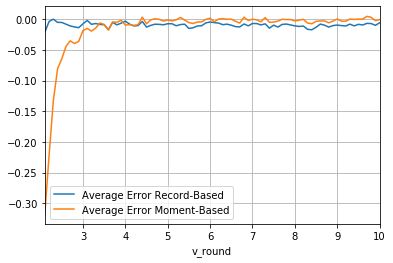

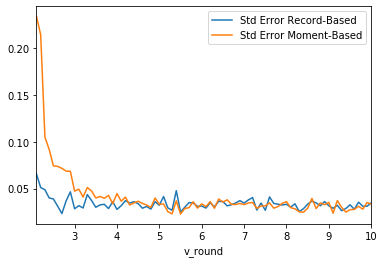

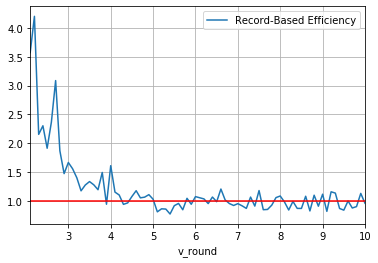

In [31]:
plot_error(m, X_test, Y_test, SR_moment_test, scaler, 'v', by_n = True, scatter_plot = False)

## The Neural Network has been trained using distributions with the degrees within the interval (2.1 , 30). Let's see how well it performs on data generated using distributions with v within (31,50)

In [81]:
df_41_50 = pd.read_csv('features_random_1k_ns60_pf0.5_vi41_vf60_si50_sf250')

In [82]:
X_train_41_50, X_test_41_50, Y_train_41_50, Y_test_41_50, SR_moment_test_41_50 = prepare_data(df_41_50, test_size=0.999)

In [83]:
len(SR_moment_test_41_50)

999

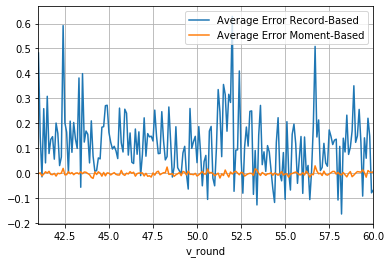

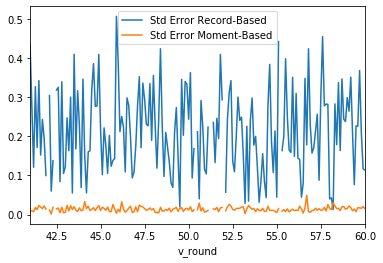

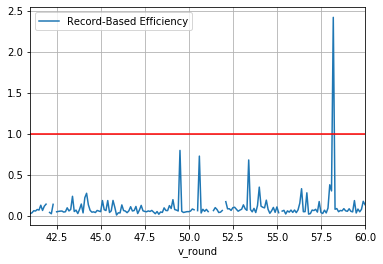

In [84]:
plot_error(m, X_test_41_50, Y_test_41_50,SR_moment_test_41_50,  scaler, scatter_plot = False)